In [1]:
import numpy as np
import matplotlib.pyplot as plt
import src.SessionNavigator as SessionNavigator
import src.SessionProcessor as SessionProcessor
from sklearn.svm import LinearSVC
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

C:\Users\Demogorgon\anaconda3\envs\Python37\lib\site-packages\allensdk\brain_observatory\comparison_utils.py:9: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
data_root = "C:/Users/Demogorgon/Documents/College/Marcus/Boston University PhD/Ocker Lab"
manifest_path = f"{data_root}/AllenSDK_Data/manifest.json"
navigator = SessionNavigator.SessionNavigator(manifest_path)
acronyms = ['VISp', 'VISl', 'VISal', 'VISrl', 'VISam', 'VISpm', 'LGd']
#stim = 'drifting_gratings_contrast'
session_ids = navigator.find_sessions(acronyms, genotype="wt/wt", session_type="functional_connectivity")
#sessions = [navigator.load_session(session_id) for session_id in session_ids]
session = navigator.load_session(session_ids[0])

In [3]:
processor = SessionProcessor.SessionProcessor(session)
unshuffled = processor.construct_decoder('drifting_gratings_contrast', 'orientation')
shuffled = processor.construct_decoder('drifting_gratings_contrast', 'orientation', shuffle_trials=True)

In [4]:
processor.construct_psth(unshuffled)
processor.calculate_decoder_weights(unshuffled)
processor.calculate_correlations(unshuffled)

processor.construct_psth(shuffled)
processor.calculate_decoder_weights(shuffled)
processor.calculate_correlations(shuffled)

In [5]:
results = processor.results()
unshuffled_results = results["drifting_gratings_contrast__width_50.0ms__unshuffled"]
shuffled_results = results["drifting_gratings_contrast__width_50.0ms__shuffled"]
keys = unshuffled_results.keys()
(num_presentations, num_bins, num_units) = unshuffled_results["psths"].shape
unit_ids = processor.all_units

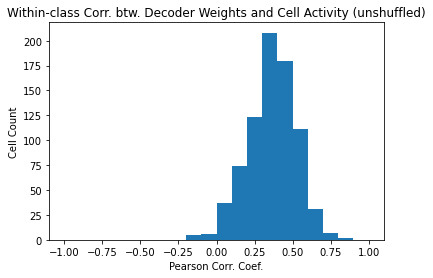

In [6]:
correlation_diagonals = unshuffled_results["within_class_correlations"]

diags = list(correlation_diagonals.values())
fig, ax = plt.subplots()
image = ax.hist(diags,bins=np.arange(-1, 1.1, 0.1))
ax.set_xlabel("Pearson Corr. Coef.")
ax.set_ylabel("Cell Count")
ax.set_title("Within-class Corr. btw. Decoder Weights and Cell Activity (unshuffled)")
plt.show()

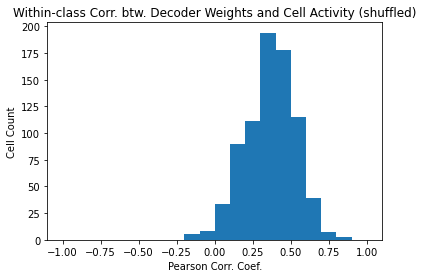

In [7]:
correlation_diagonals = shuffled_results["within_class_correlations"]

diags = list(correlation_diagonals.values())
fig, ax = plt.subplots()
image = ax.hist(diags,bins=np.arange(-1, 1.1, 0.1))
ax.set_xlabel("Pearson Corr. Coef.")
ax.set_ylabel("Cell Count")
ax.set_title("Within-class Corr. btw. Decoder Weights and Cell Activity (shuffled)")
plt.show()

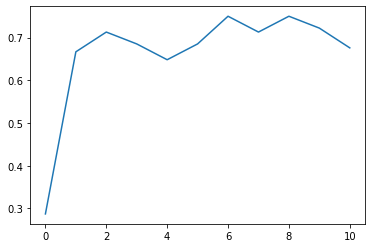

In [8]:
decoder = unshuffled_results["decoder"]
accuracies = decoder.accuracies_by_bin
x = list(accuracies.keys())
y = (accuracies.values())

fig, ax = plt.subplots()
image = ax.plot(x, y)
plt.show()

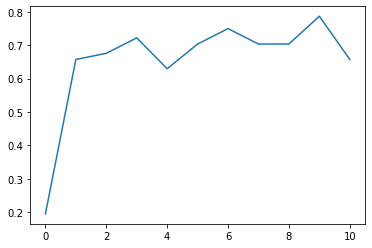

In [9]:
decoder = shuffled_results["decoder"]
accuracies = decoder.accuracies_by_bin
x = list(accuracies.keys())
y = (accuracies.values())

fig, ax = plt.subplots()
image = ax.plot(x, y)
plt.show()

In [7]:
import pickle as pkl
full_path = "C:/Users/Demogorgon/Documents/College/Marcus/Boston University PhD/Ocker Lab/correlations_and_bursts/results"
with open(f"{full_path}/first_example_processor.pkl", 'wb') as f:
        pkl.dump(processor, f)

In [2]:
import pickle as pkl
from compress_pickle import dump, load
full_path = "C:/Users/Demogorgon/Documents/College/Marcus/Boston University PhD/Ocker Lab/correlations_and_bursts/results"
with open(f"{full_path}/first_example_processor.pkl", 'r') as f:
        processor = pkl.load(f)
# with open(f"{full_path}/first_example_processor.pkl", 'wb') as f:
#         pkl.dump(processor, f)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte